[View in Colaboratory](https://colab.research.google.com/github/abhinavrk/GoogleColabMusings/blob/master/char_rnn_generation_assignment4.ipynb)

In [6]:
loaded = False

if not loaded:
  # http://pytorch.org/
  from os import path
  from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
  platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

  accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

  !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

  import torch
  loaded = True

  !wget https://download.pytorch.org/tutorial/data.zip
  !unzip data.zip



tcmalloc: large alloc 1073750016 bytes == 0x5b1b2000 @  0x7f4559aa91c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
--2018-07-19 17:16:07--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.80.53, 13.32.80.22, 13.32.80.66, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.80.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  5.43MB/s    in 0.5s    

2018-07-19 17:16:08 (5.43 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt 

In [0]:
%matplotlib inline

In [8]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['German', 'Spanish', 'Czech', 'Dutch', 'Portuguese', 'Vietnamese', 'Greek', 'Irish', 'Russian', 'Polish', 'Scottish', 'Arabic', 'Italian', 'Japanese', 'English', 'French', 'Chinese', 'Korean']
O'Neal


In [0]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [0]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [0]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
import torch
import torch.nn as nn

class RNN_phidden_pchar_category(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_phidden_pchar_category, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
class RNN_phidden_pchar(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_phidden_pchar, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class RNN_phidden_category(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_phidden_category, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class RNN_phidden(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_phidden, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = hidden
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(rnn, category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [0]:
def do_train(rnn, all_losses):

  n_iters = 100000
  print_every = 5000
  plot_every = 500
  total_loss = 0 # Reset every plot_every iters

  start = time.time()

  for iter in range(1, n_iters + 1):
      output, loss = train(rnn, *randomTrainingExample())
      total_loss += loss

      if iter % print_every == 0:
          print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

      if iter % plot_every == 0:
          all_losses.append(total_loss / plot_every)
          total_loss = 0

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

rnn_phidden_pchar_category = RNN_phidden_pchar_category(
    n_letters, 128, n_letters)
all_losses_phidden_pchar_category = []
do_train(rnn_phidden_pchar_category, all_losses_phidden_pchar_category)

0m 19s (5000 5%) 2.7248
0m 37s (10000 10%) 3.9466
0m 56s (15000 15%) 2.6862
1m 14s (20000 20%) 2.7262
1m 32s (25000 25%) 3.1803
1m 51s (30000 30%) 3.5821
2m 9s (35000 35%) 1.8479
2m 27s (40000 40%) 2.2864
2m 46s (45000 45%) 2.8863
3m 4s (50000 50%) 2.8141
3m 23s (55000 55%) 2.7692
3m 41s (60000 60%) 2.2108
3m 59s (65000 65%) 1.7947
4m 18s (70000 70%) 2.1070
4m 36s (75000 75%) 2.3476
4m 55s (80000 80%) 1.4672
5m 13s (85000 85%) 2.5636
5m 32s (90000 90%) 1.6605
5m 50s (95000 95%) 1.9547
6m 8s (100000 100%) 2.3678


In [20]:
rnn_phidden_pchar = RNN_phidden_pchar(
    n_letters, 128, n_letters)
all_losses_phidden_pchar = []
do_train(rnn_phidden_pchar, all_losses_phidden_pchar)

0m 18s (5000 5%) 2.9882
0m 36s (10000 10%) 3.0549
0m 54s (15000 15%) 2.0473
1m 12s (20000 20%) 4.5419
1m 30s (25000 25%) 3.3534
1m 48s (30000 30%) 2.9023
2m 6s (35000 35%) 2.9665
2m 24s (40000 40%) 3.0133
2m 42s (45000 45%) 2.5738
3m 0s (50000 50%) 1.9352
3m 18s (55000 55%) 2.7330
3m 37s (60000 60%) 2.6059
3m 55s (65000 65%) 2.4177
4m 12s (70000 70%) 2.3204
4m 30s (75000 75%) 2.7478
4m 49s (80000 80%) 2.3153
5m 7s (85000 85%) 2.4734
5m 25s (90000 90%) 3.1380
5m 43s (95000 95%) 2.5506
6m 2s (100000 100%) 3.3026


In [22]:
rnn_phidden_category = RNN_phidden_category(
    n_letters, 128, n_letters)
all_losses_phidden_category = []
do_train(rnn_phidden_category, all_losses_phidden_category)

0m 18s (5000 5%) 2.5482
0m 36s (10000 10%) 2.7480
0m 53s (15000 15%) 3.4603
1m 11s (20000 20%) 2.5771
1m 29s (25000 25%) 2.3708
1m 47s (30000 30%) 2.3363
2m 5s (35000 35%) 2.9422
2m 24s (40000 40%) 3.0751
2m 42s (45000 45%) 3.1855
3m 0s (50000 50%) 2.7816
3m 18s (55000 55%) 1.7097
3m 36s (60000 60%) 3.0728
3m 53s (65000 65%) 2.9020
4m 12s (70000 70%) 2.1645
4m 30s (75000 75%) 3.1454
4m 48s (80000 80%) 2.3910
5m 6s (85000 85%) 1.9533
5m 24s (90000 90%) 2.2359
5m 42s (95000 95%) 2.3405
5m 59s (100000 100%) 2.7867


In [23]:
rnn_phidden = RNN_phidden(
    n_letters, 128, n_letters)
all_losses_phidden = []
do_train(rnn_phidden, all_losses_phidden)

0m 17s (5000 5%) 3.2473
0m 34s (10000 10%) 3.2283
0m 51s (15000 15%) 2.7110
1m 9s (20000 20%) 2.9242
1m 26s (25000 25%) 2.5051
1m 43s (30000 30%) 2.4999
2m 0s (35000 35%) 3.1925
2m 17s (40000 40%) 2.9240
2m 34s (45000 45%) 2.5948
2m 51s (50000 50%) 2.6693
3m 8s (55000 55%) 2.3358
3m 26s (60000 60%) 3.0185
3m 43s (65000 65%) 2.2817
4m 0s (70000 70%) 2.2181
4m 17s (75000 75%) 2.6257
4m 34s (80000 80%) 2.9874
4m 51s (85000 85%) 2.7040
5m 8s (90000 90%) 2.8835
5m 25s (95000 95%) 2.8821
5m 42s (100000 100%) 2.9199


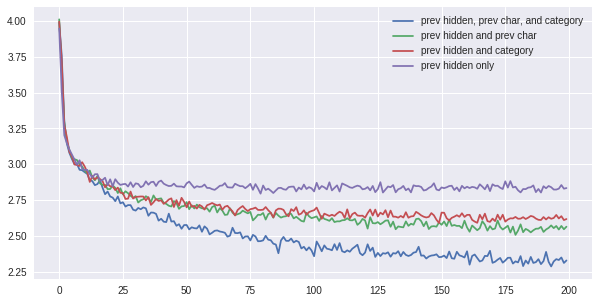

In [25]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(
    all_losses_phidden_pchar_category,
    label='prev hidden, prev char, and category')

plt.plot(
    all_losses_phidden_pchar,
    label='prev hidden and prev char')

plt.plot(
    all_losses_phidden_category,
    label='prev hidden and category')

plt.plot(
    all_losses_phidden,
    label='prev hidden only')

plt.legend()